# Final Project
#### Daniel Saba

This project is about car speed detection.  
In order the get the speed, there is a simple formula  
<b>Speed =  Distance / Time </b>.  
In my situation, i had to guess the distance(took a part from the road).  
To help myself with the guessing, i managed to come up with the same video as i used on youtube that detected the speeds, and i did several comparisons.  
In order to get the time, i have counted the frames that each car detected took to pass through the fraction of the road, and then devided it with the FPS (frames per second).  
In order to detect the cars, i took a clean sample of the road, and from each frame of the video I used absdiff fuction with the clean sample and the new frame.  
To be able to distinguish and dissociate within the lanes, I have used cv2.HoughLines. 
The speed calculated is KMH

<B>Some limitations i had :</B>  
starting with choosing the approach to solve this problem, i have tryed to work with optical flow, but i have noticed that it is hard to work with points and to dissociate them with each lane, further more, it was much more difficult to calculate the car speed.  
another thing that demanded from me to put some efforts in thinking is the way to visulaize the output, i have thought about a bounding the cars in a box and the speed will be written underneath each box (pretty known and boring), so i managed to slightly prove (I think), and sticked the pictures of each car detected above, so in further work, it will be easier to approach the cars (license plate detection, etc.) and to save the cars in a database.

<B> Workflow </B>  
* Detecting lines in the road (HoughLines)
* Splitting the lines into lanes (findContour)
* Detect each car on each lane (absdiff)
* Counting the frames the car took to pass the road fraction
* Calculate the car speed (guessing the distance)
* Visulaize each car and its speed

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
#from sklearn.cluster import KMeans

In [2]:
cap = cv2.VideoCapture("cars.mp4")

ret,first_F = cap.read()
ret,first_F = cap.read()

# splitting the screen into lines; 
clean_mainroad1 = first_F[150:240,80:630]


clean_mainroad1g = cv2.cvtColor(clean_mainroad1,cv2.COLOR_RGB2GRAY)
canvas = np.zeros_like(clean_mainroad1g)

clean_mainroad1g_canny = cv2.Canny(clean_mainroad1g,100,255,apertureSize=3)
lines = cv2.HoughLines(clean_mainroad1g_canny,rho=1,theta=np.pi/180,threshold=30)

#getting the lines detected
for rho,theta in lines[:,0,:]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    #giving a +10 pixel range right and down to move the lanes a little bit, so the cars will fit(because of the camera angle)
    cv2.arrowedLine(canvas,(x1+10,y1),(x2+15,y2),(255),5)
    cv2.erode(canvas,np.ones((5,5)),iterations=2)


canvas = cv2.bitwise_not(canvas)

#splitting the lanes and getting them as a contour
_,ctrs,hierarchy = cv2.findContours(canvas, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

newcanvas = np.zeros_like(canvas)

lanes = {}
lanes_masks = []
j=1
for i in range(2,7):
    newcanvas = np.zeros_like(clean_mainroad1g)
    cv2.fillPoly(newcanvas,[ctrs[i]], color=(1))
    rot_rect = cv2.minAreaRect(ctrs[i])
    box = np.int64(cv2.boxPoints(rot_rect))
    lanes.update({str(j):box})
    j+=1
    lanes_masks.append(newcanvas)

### These are the lanes that i have detected

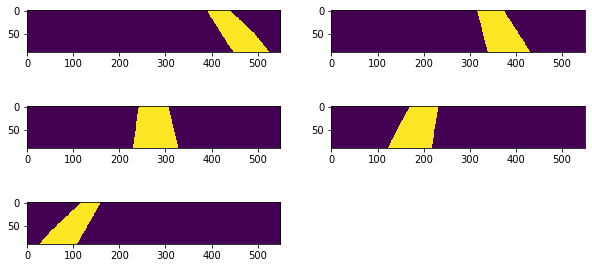

In [3]:
fig = plt.figure(figsize = (10,5))
fig1 = fig.add_subplot(3,2,1)
fig1.imshow(lanes_masks[0])
fig2 = fig.add_subplot(3,2,2)
fig2.imshow(lanes_masks[1])
fig3 = fig.add_subplot(3,2,3)
fig3.imshow(lanes_masks[2])
fig4 = fig.add_subplot(3,2,4)
fig4.imshow(lanes_masks[3])
fig5 = fig.add_subplot(3,2,5)
fig5.imshow(lanes_masks[4])
plt.show()

In [4]:
#this function does the absdiff and returns a mask of each lane
def getLaneMask(Lane2_2,Lane2):
    frameDiff = cv2.absdiff(Lane2_2,Lane2)
    _, mask = cv2.threshold(frameDiff,40,255, cv2.THRESH_BINARY)
    mask = cv2.dilate(mask,np.ones((3,3)),iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3)), iterations=3)
    mask = cv2.erode(mask,np.ones((5,5)),iterations=2) 
    return mask

#this method returns the trimmed car from the newest frame
def get_car_pic(mask_lane2,clean_mainroad1):
    (y, x) = np.where(mask_lane2 == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = clean_mainroad1[topy:bottomy+5, topx-10:bottomx+5]
    return out

In [5]:
cap = cv2.VideoCapture("cars.mp4")

ret,first_F = cap.read()
clean_mainroad1 = first_F[150:240,80:630]
clean_mainroad1g = cv2.cvtColor(clean_mainroad1,cv2.COLOR_RGB2GRAY)
timer_lane0,timer_lane1,timer_lane2,timer_lane3,timer_lane4 = 0,0,0,0,0
count0,count1,count2,count3,count4 = 0,0,0,0,0

lane0_car = False
lane1_car = False
lane2_car = False
lane3_car = False
lane4_car = False

car_photo0 = False
car_photo1 = False
car_photo2 = False
car_photo3 = False
car_photo4 = False

l = []
l2 = []

#getting the lanes splitted for clean road frame, to use absdiff
Lane0 = clean_mainroad1g*lanes_masks[0]
Lane1 = clean_mainroad1g*lanes_masks[1]
Lane2 = clean_mainroad1g*lanes_masks[2]
Lane3 = clean_mainroad1g*lanes_masks[3]
Lane4 = clean_mainroad1g*lanes_masks[4]

fps = cap.get(cv2.CAP_PROP_FPS)
x_offset=y_offset=0
while True:
    ret,newFrame2 = cap.read()
    # detecting the cars, id the car, point speeed 
    if(ret == True):      
        clean_mainroad2 = newFrame2[150:240,80:630]
        clean_mainroadg2 = cv2.cvtColor(clean_mainroad2,cv2.COLOR_RGB2GRAY)
        #making the frames to use absdiff with the new frame loaded.
        Lane2_0 = clean_mainroadg2*lanes_masks[0]
        Lane2_1 = clean_mainroadg2*lanes_masks[1]
        Lane2_2 = clean_mainroadg2*lanes_masks[2]
        Lane2_3 = clean_mainroadg2*lanes_masks[3]
        Lane2_4 = clean_mainroadg2*lanes_masks[4]
        
        mask_lane0 = getLaneMask(Lane2_0,Lane0)
        mask_lane1 = getLaneMask(Lane2_1,Lane1)
        mask_lane2 = getLaneMask(Lane2_2,Lane2)
        mask_lane3 = getLaneMask(Lane2_3,Lane3)
        mask_lane4 = getLaneMask(Lane2_4,Lane4)
            
        # getting the speed of ea lane
        #lane 0
        lane0_sum = sum(mask_lane0.flatten())
        if(lane0_sum > 1000 and lane0_car == False):
            lane0_car = True
        if(lane0_sum == 0 and lane0_car == True):
            lane0_car = False
            timer_lane0 = (15/(count0/fps))*(3600/1000)
            count0 = 1
            if(car_photo0 == True):
                l.append(car_pic0)
                l2.append(timer_lane0)
            car_photo0 = False
        if(lane0_car == True):
            count0+=1
        if(sum(mask_lane0[0][:]) > 0 and car_photo0 is False and lane0_sum > 100):
            car_pic0 = get_car_pic(mask_lane0,clean_mainroad2) 
            car_photo0 = True
            
            # lane 1
        lane1_sum = sum(mask_lane1.flatten())
        if(lane1_sum > 5000 and lane1_car == False):
            lane1_car = True
        if(lane1_sum == 0 and lane1_car == True):
            lane1_car = False
            timer_lane1 = (13/(count1/fps))*(3600/1000)
            count1=0
            if(car_photo1 == True and lane1_car == False):
                l.append(car_pic1)
                l2.append(timer_lane1)
            car_photo1 = False
        if(lane1_car == True):
            count1+=1
        if(sum(mask_lane1[0][:]) > 0 and car_photo1 is False and lane1_sum > 200000):
            car_pic1 = get_car_pic(mask_lane1,clean_mainroad2) 
            car_photo1 = True
            
            #lane2
        lane2_sum = sum(mask_lane2.flatten())
        if(lane2_sum > 100000 and lane2_car == False):
            lane2_car = True
        if(lane2_sum == 0 and lane2_car == True):
            timer_lane2 =  (14/(count2/fps))*(3600/1000) # convert to hours
            lane2_car = False
            count2=0
            if(car_photo2 == True and lane2_car == False):
                l.append(car_pic2)
                l2.append(timer_lane2)
            car_photo2 = False 
        if(lane2_car == True):
            count2+=1
        if(sum(mask_lane2[0][:]) > 100 and car_photo2 is False and lane2_sum > 200000):
            car_pic2 = get_car_pic(mask_lane2,clean_mainroad2) 
            car_photo2 = True
        
            #lane3
        lane3_sum = sum(mask_lane3.flatten())
        if(lane3_sum > 15000 and lane3_car == False):
            lane3_car = True
        if(lane3_sum == 0 and lane3_car == True):
            timer_lane3 = (14.5/(count3/fps))*(3600/1000)
            lane3_car = False
            count3=0
            if(car_photo3 == True):
                l.append(car_pic3)
                l2.append(timer_lane3)
            car_photo3 = False
        if(lane3_car == True):
            count3+=1
        if(sum(mask_lane3[0][:]) > 100 and car_photo3 is False and lane3_sum > 100000):
            car_pic3 = get_car_pic(mask_lane3,clean_mainroad2) 
            car_photo3 = True
        
            #lane4
        lane4_sum = sum(mask_lane4.flatten())
        if(lane4_sum > 15000 and lane4_car == False):
            lane4_car = True
        if(lane4_sum == 0 and lane4_car == True):
            timer_lane4 = (14/(count4/fps))*(3600/1000)
            lane4_car = False
            count4=0
            if(car_photo4 == True):
                l.append(car_pic4)
                l2.append(timer_lane4)
            car_photo4 = False
        if(lane4_car == True):
            count4+=1
        if(sum(mask_lane4[0][:]) > 100 and car_photo4 is False and lane4_sum > 100000):
            car_pic4 = get_car_pic(mask_lane4,clean_mainroad2) 
            car_photo4 = True
        
        #showing the cars and their speeds
        for car,speed in zip(l,l2):
            out = cv2.copyMakeBorder(car,5,5,5,5,cv2.BORDER_CONSTANT, (0,0,255))
            newFrame2[y_offset:y_offset+car.shape[0]+10,x_offset:x_offset + car.shape[1]+10] = out
            cv2.putText(newFrame2,str(round(speed,1)),(x_offset + 10,y_offset+car.shape[0] + 10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
            x_offset = x_offset + car.shape[1]
            
        y_offset = 0
        x_offset = 0
        if(len(l) > 5):
            l = l[-5:]
            l2 = l2[-5:]
        cv2.imshow("Cars",newFrame2)
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1);